In [147]:
import numpy as np
import flow
import os
import tensortools as tt
import cascade as cas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from munkres import Munkres
from scipy import linalg
import pandas as pd

done.
done.
done.
done.
done.


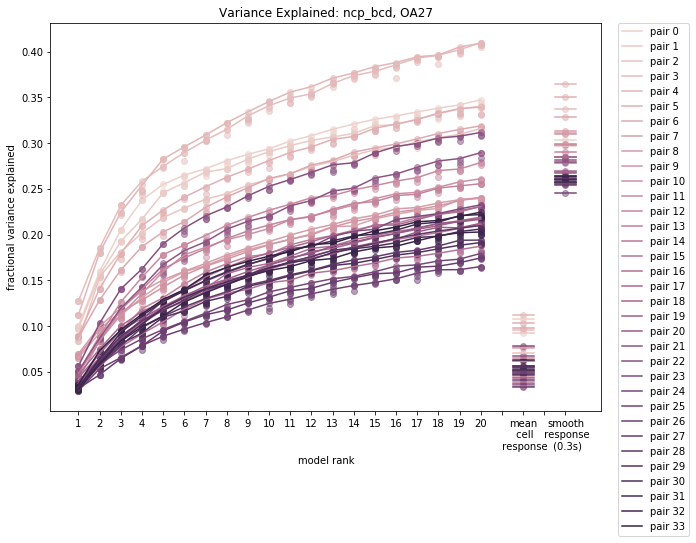

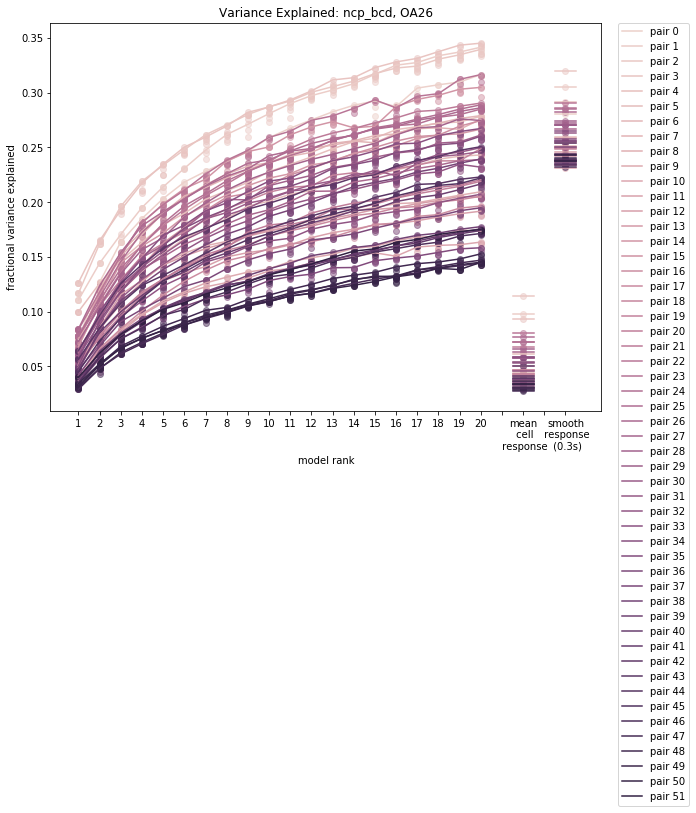

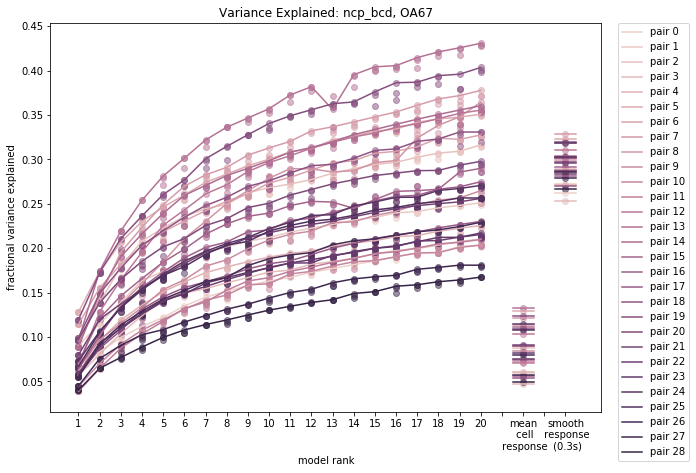

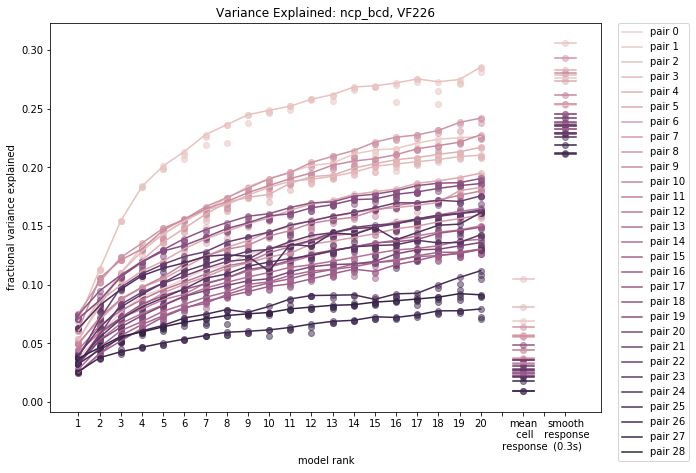

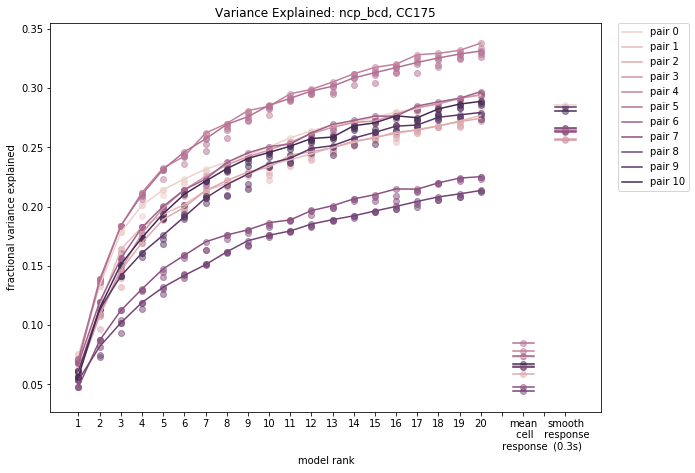

In [116]:
for mouse in ['OA27', 'OA26', 'OA67', 'VF226', 'CC175']:
    # mouse = 'OA27'
    trace_type = 'zscore'
    days = flow.DateSorter.frommeta(mice=[mouse], tags=None)
    m = 'ncp_bcd'
    
    cmap = sns.color_palette(sns.cubehelix_palette(len(days)))
#     cmap = sns.color_palette('hls', n_colors=len(days))
#     dmap = sns.hls_palette(len(days), l=.3, s=.8)

    # create figure and axes
    buffer = 5
    right_pad = 5
    # fig = plt.figure(figsize=(24,6))
    fig = plt.figure(figsize=(10,8))
    gs = GridSpec(100, 100, figure=fig, left=0.05, right=.95, top=.95, bottom=0.05)
    ax = fig.add_subplot(gs[10:90-buffer, :90-right_pad])
    # ax = fig.add_subplot(gs[10:90-buffer, :30-right_pad])
    # ax1 = fig.add_subplot(gs[10:90-buffer, 30:60-right_pad])
    # ax2 = fig.add_subplot(gs[10:90-buffer, 60:90-right_pad])

    for c, day1 in enumerate(days, 0):
        try:
            day2 = days[c+1]
        except IndexError:
            print('done.')
            break

        # create folder structure if needed
        # load
        out_dir = os.path.join(flow.paths.outd, str(day1.mouse))
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        load_dir = os.path.join(out_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(load_dir):
            os.mkdir(load_dir)
        tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
        input_tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_tensor_' + str(trace_type) + '.npy')

        # save
        ana_dir = os.path.join(flow.paths.graphd, str(day1.mouse))
        if not os.path.isdir(ana_dir):
            os.mkdir(ana_dir)
        save_dir = os.path.join(ana_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        save_dir = os.path.join(save_dir, 'qc')
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        var_path = os.path.join(save_dir, str(day1.mouse) + '_summary_variance_cubehelix.png')

        # load your data
        ensemble = np.load(tensor_path)
        ensemble = ensemble.item()

        V = ensemble[m]
        X = np.load(input_tensor_path)

    #     # get number of ranks 
    #     x = np.array(V.results.keys())

        # get reconstruction error as variance explained
        var, var_s, x, x_s = [], [], [], []
        for r in V.results:
            bU = V.results[r][0].factors.full()
            var.append((np.var(X) - np.var(X - bU)) / np.var(X))
            x.append(r)
            for it in range(0, len(V.results[r])):
                U = V.results[r][it].factors.full()
                var_s.extend([(np.var(X) - np.var(X - U)) / np.var(X)])
                x_s.extend([r])

        # get reconstruction error controls as variance explained
        var_smooth, var_mean = [], []

        # mean response of neuron across trials 
        mU = np.mean(X, axis=2, keepdims=True) * np.ones((1,1,np.shape(X)[2]))
        var_mean = (np.var(X) - np.var(X - mU)) / np.var(X) 
        # mean response of neuron across trials
        smU = np.convolve(X.reshape((X.size)), np.ones(5, dtype=np.float64)/5, 'same').reshape(np.shape(X))
        var_smooth = (np.var(X) - np.var(X - smU)) / np.var(X)

        r = len(V.results)
        ax.scatter(x_s, var_s, color=cmap[c], alpha=0.5)
        ax.scatter([r+2], var_mean, color=cmap[c], alpha=0.5)
        ax.scatter([r+4], var_smooth, color=cmap[c], alpha=0.5)
        ax.plot(x, var, label=('pair ' + str(c)), color=cmap[c])
        ax.plot([r+1.5, r+2.5], [var_mean, var_mean], color=cmap[c])
        ax.plot([r+3.5, r+4.5], [var_smooth, var_smooth], color=cmap[c])
        x_labels = [str(r) for r in V.results]
        x_labels.extend(['', 'mean\n cell\n response', '', 'smooth\n response\n (0.3s)'])
    #     x_labels.append('mean\n cell\n response')
        ax.set_xticks(range(1,len(V.results)+5))
        ax.set_xticklabels(x_labels)
        ax.set_xlabel('model rank')
        ax.set_ylabel('fractional variance explained')
        ax.set_title('Variance Explained: ' + str(m) + ', ' + mouse)
        ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

    #     ax1.plot(x, var_mean, label=('pair ' + str(c)), color=cmap[c])
    #     ax1.set_xlabel('model rank')
    #     ax1.set_ylabel('fractional variance explained')
    #     ax1.set_title('Variance explained by mean cell response: ' + str(m) + ', ' + mouse)
    #     ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

    #     ax2.plot(x, var_smooth, label=('pair ' + str(c)), color=cmap[c])
    #     ax2.set_xlabel('model rank')
    #     ax2.set_ylabel('fractional variance explained')
    #     ax2.set_title('Variance explained by smoothing: ' + str(m) + ', ' + mouse)
    #     ax2.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)


    fig.savefig(var_path, bbox_inches='tight')
    #     ax.show()


In [120]:
R = np.max([r for r in V.results.keys()])
R

20

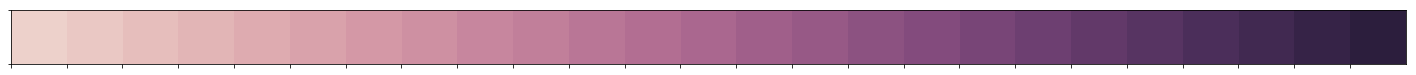

In [111]:
sns.palplot(sns.cubehelix_palette(25))

In [61]:
print(linalg.norm(X))
print(linalg.norm(X - U))
obj = linalg.norm(X - U) / linalg.norm(X)
print(obj)

3140.9046310413655
2792.3900226209585
0.8890400539462234


In [62]:
print(np.var(X))
print(np.var(X - U))
obj = np.var(X - U) / np.var(X)
print(obj)
print((np.var(X) - np.var(X - U)) / np.var(X) )

0.8210453425295249
0.6517949162022779
0.7938598301942615
0.20614016980573846


In [216]:
mouse = 'CC175'
method = 'ncp_bcd'
trace_type = 'zscore'
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

cmap = sns.color_palette(sns.cubehelix_palette(len(days)))

ve, ve_max, ve_frac, rank_num, day_num, cell_num = [], [], [], [], [], []
for c, day1 in enumerate(days, 0):
    try:
        day2 = days[c+1]
    except IndexError:
        print('done.')
        break

    # create folder structure if needed
    # load dirs
    out_dir = os.path.join(flow.paths.outd, str(day1.mouse))
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    load_dir = os.path.join(out_dir, 'tensors paired ' + str(trace_type))
    if not os.path.isdir(load_dir):
        os.mkdir(load_dir)
    tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                     + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                     + '_' + str(day2.date) + '_pair_tensor_' + str(trace_type) + '.npy')

    # save dirs
    ana_dir = os.path.join(flow.paths.graphd, str(day1.mouse))
    if not os.path.isdir(ana_dir):
        os.mkdir(ana_dir)
    save_dir = os.path.join(ana_dir, 'tensors paired ' + str(trace_type))
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, 'qc')
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    var_path = os.path.join(save_dir, str(day1.mouse) + '_summary_variance_cubehelix.png')

    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    V = ensemble[method]
    X = np.load(input_tensor_path)

    # get reconstruction error as variance explained by cell
#     U20 = X - V.results[20][0].factors.full()
    for cell in range(0, np.shape(X)[0]):
        rank_ve_vec = []
        rank_vec = []
        for r in V.results:
            U = V.results[r][0].factors.full()
            Usub = X - U
            rank_ve = (np.var(X[cell,:,:]) - np.var(Usub[cell,:,:])) / np.var(X[cell,:,:])
#             max_ve = (np.var(X[cell,:,:]) - np.var(U20[cell,:,:])) / np.var(X[cell,:,:])
            rank_ve_vec.append(rank_ve)
            rank_vec.append(r)
        max_ve = np.max(rank_ve_vec)
        ve.extend(rank_ve_vec)
        ve_max.extend([max_ve for s in rank_ve_vec])
        ve_frac.extend(rank_ve_vec/max_ve)
        rank_num.extend(rank_vec)
        day_num.extend([c+1 for s in rank_ve_vec])
        cell_num.extend([cell for s in rank_ve_vec])
#             trial_num.append(trial)

    
#         # mean response of neuron across trials
#         mU = np.mean(X, axis=2, keepdims=True) * np.ones((1, 1, np.shape(X)[2]))
#         var_mean = (np.var(X) - np.var(X - mU)) / np.var(X)

#         # smoothed response of neuron across time
#         smU = np.convolve(X.reshape((X.size)), np.ones(5, dtype=np.float64)/5, 'same').reshape(np.shape(X))
#         var_smooth = (np.var(X) - np.var(X - smU)) / np.var(X)

#         # plot
#         R = np.max([r for r in V.results.keys()])
#         ax.scatter(x_s, var_s, color=cmap[c], alpha=0.5)
#         ax.scatter([R+2], var_mean, color=cmap[c], alpha=0.5)
#         ax.scatter([R+4], var_smooth, color=cmap[c], alpha=0.5)
#         ax.plot(x, var, label=('pair ' + str(c)), color=cmap[c])
#         ax.plot([R+1.5, R+2.5], [var_mean, var_mean], color=cmap[c])
#         ax.plot([R+3.5, R+4.5], [var_smooth, var_smooth], color=cmap[c])

#     # add labels/titles
#     x_labels = [str(R) for R in V.results]
#     x_labels.extend(['', 'mean\n cell\n response', '', 'smooth\n response\n (0.3s)'])
#     ax.set_xticks(range(1, len(V.results) + 5))
#     ax.set_xticklabels(x_labels)
#     ax.set_xlabel('model rank')
#     ax.set_ylabel('fractional variance explained')
#     ax.set_title('Variance Explained: ' + str(method) + ', ' + mouse)
#     ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

#     fig.savefig(var_path, bbox_inches='tight')

/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


done.


In [204]:
cell_num = np.concatenate(cell_num)
# for i in range(np.shape(Usub)[2]):
#     for k in range(np.shape(Usub)[0]):
#         if np.var(X[k,:,i]) < np.var(Usub[k,:,i]):
#     #         print(np.var(Usub))
#     #         print(np.var(X))
#             print(count)
#             print(np.var(Usub[k,:,i]))
#             print(np.var(X[k,:,i]))
#             count = count + 1

In [217]:
index = pd.MultiIndex.from_arrays([
    day_num,
    rank_num,
    ve,
    ve_max,
    ve_frac,
    cell_num,
    ],
    names=['day', 'rank', 'variance_explained', 'max_ve', 'frac_ve', 'cell'])
df = pd.DataFrame(index=index)
df = df.reset_index()
# day_indexer = df.IndexSlice[:, :]
# rank_indexer = df.
# sliced_df = 
# sns.violinplot(x=sliced_df[,'cell_num'], y=sliced_df[,'variance'], palette="Blues")
df.head()

,day,rank,variance_explained,max_ve,frac_ve,cell
0,1,1,-0.000775,0.316839,-0.002445,0
1,1,2,0.001525,0.316839,0.004812,0
2,1,3,0.004717,0.316839,0.014886,0
3,1,4,0.007415,0.316839,0.023404,0
4,1,5,0.007145,0.316839,0.022551,0


In [345]:
np.unique(df['rank'])[-1]

20

Text(0.5, 1.0, 'CC175, Variance explained per cell, day 1')

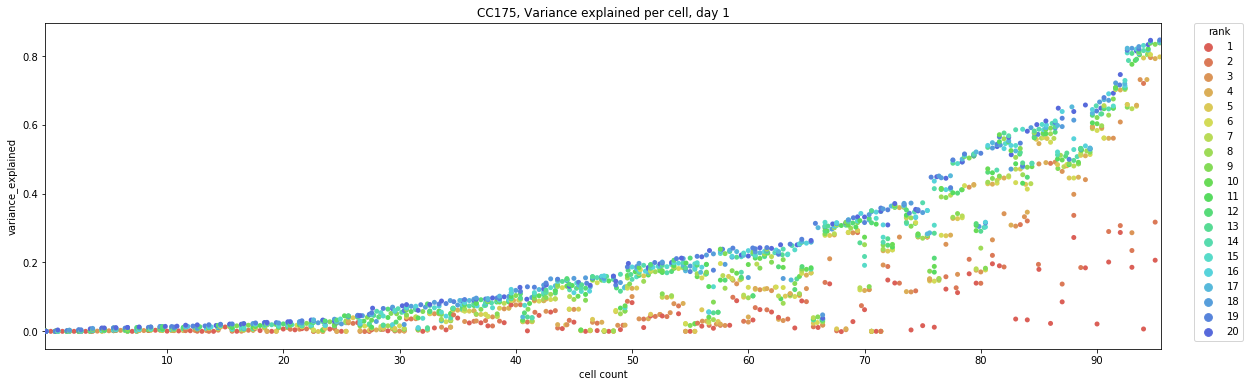

In [353]:
# plot "cell" (approximate, this is by unique max_ve not cells per se)
# for d in np.unique(df['day']):
d = 1
# slice df, one plot per day
sliced_df = df.loc[(df['day'] == d),:]

# make a rainbow colormap, HUSL space but does not circle back on itself
cmap = sns.color_palette('hls', int(np.ceil(1.5*np.unique(df['rank'])[-1])))
cmap = cmap[0:np.unique(df['rank'])[-1]]

fig0 = plt.figure(figsize=(20,6))
ax0 = sns.swarmplot(x=sliced_df['max_ve'], y=sliced_df['variance_explained'], hue=sliced_df['rank'], palette=cmap)
l = ax0.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
l.set_title('rank')
ax0.set_xlabel('cell count')
x_lim = ax0.get_xlim()
ticks = ax0.get_xticks()
new_ticks = [t for t in ticks[10::10]]
ax0.set_xticks(new_ticks)
ax0.set_xticklabels(np.arange(10,len(ticks),10))
ax0.set_title(mouse + ', Variance explained per cell, day ' + str(d))
                             

<Figure size 432x288 with 0 Axes>

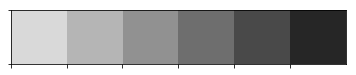

<Figure size 432x288 with 0 Axes>

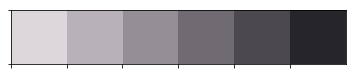

<Figure size 432x288 with 0 Axes>

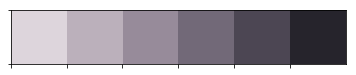

<Figure size 432x288 with 0 Axes>

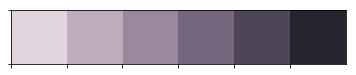

<Figure size 432x288 with 0 Axes>

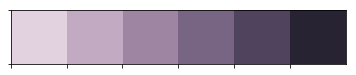

<Figure size 432x288 with 0 Axes>

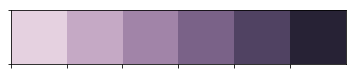

<Figure size 432x288 with 0 Axes>

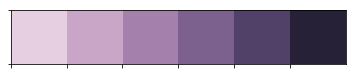

<Figure size 432x288 with 0 Axes>

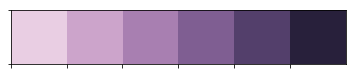

<Figure size 432x288 with 0 Axes>

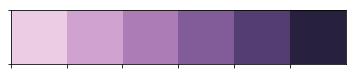

<Figure size 432x288 with 0 Axes>

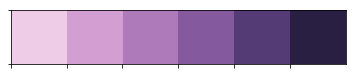

In [331]:

for i in np.arange(0,1,.1):
    plt.figure()
    sns.palplot(sns.cubehelix_palette(rot=0.2, hue=i))

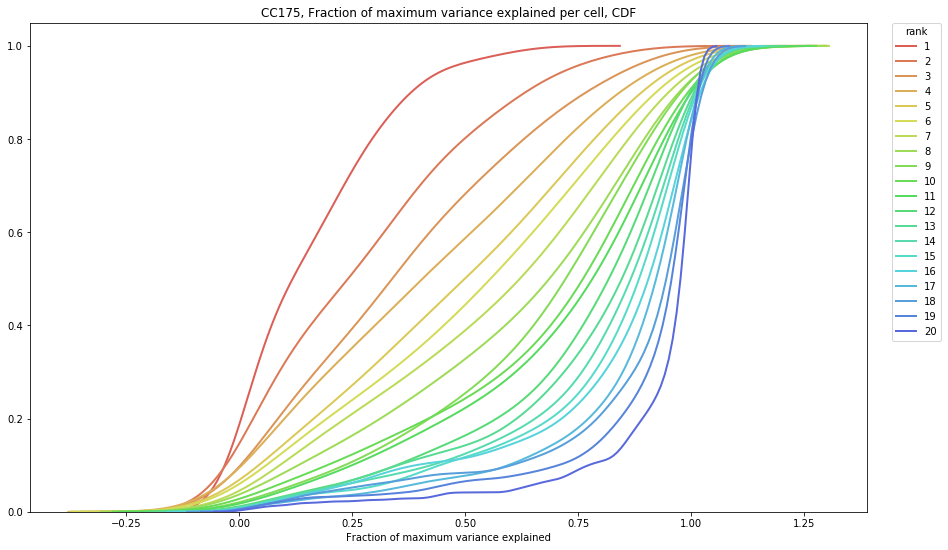

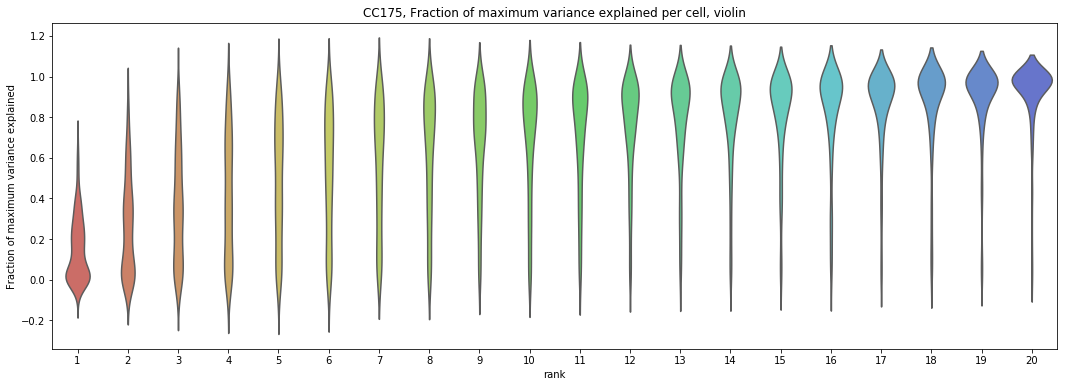

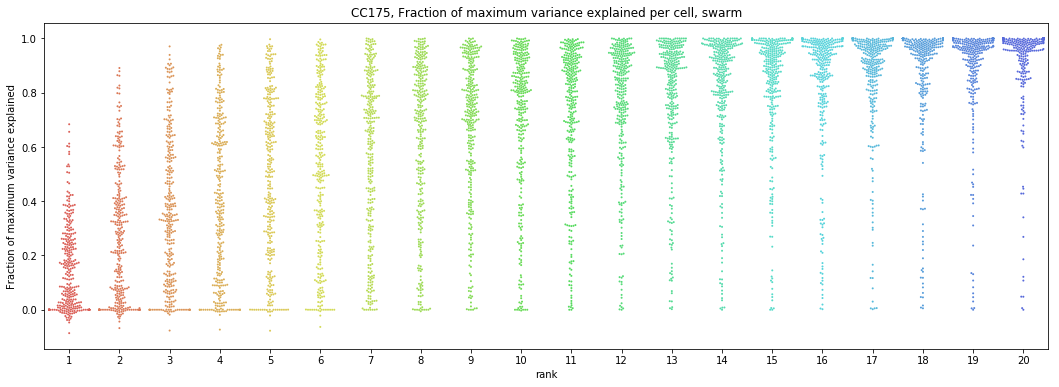

In [363]:
# build pd dataframe of all variance measures
index = pd.MultiIndex.from_arrays([
    day_num,
    rank_num,

    ve,
    ve_max,
    ve_frac,
    cell_num,
    ],
    names=['day', 'rank', 'variance_explained', 'max_ve', 'frac_ve', 'cell'])
df = pd.DataFrame(index=index)
df = df.reset_index()

# make a rainbow colormap, HUSL space but does not circle back on itself
cmap = sns.color_palette('hls', int(np.ceil(1.5*np.unique(df['rank'])[-1])))
cmap = cmap[0:np.unique(df['rank'])[-1]]

# Part 1
# slice df, only look at cells with a max variance >5%
sliced_df2 = df.loc[(df['day']) & (df['max_ve'] >= 0.05) & (df['max_ve'] <= 1.00),:]

# CDF plot
fig1 = plt.figure(figsize=(15,9))
for i in np.unique(sliced_df2['rank']):
    input_ve = sliced_df2.loc[(sliced_df2['rank'] == i),'frac_ve']
    ax = sns.distplot(input_ve, kde_kws={'cumulative': True, 'lw': 2, 'color': cmap[i-1], 'label': str(i)}, hist=False)
    l = ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
    l.set_title('rank')
    ax.set_title(mouse + ', Fraction of maximum variance explained per cell, CDF')
    ax.set_xlabel('Fraction of maximum variance explained')

# swarm plot
fig2 =plt.figure(figsize=(18,6))
ax2 = sns.violinplot(x=sliced_df2['rank'], y=sliced_df2['frac_ve'], size=3, alpha=1, inner=None, palette=cmap)
ax2.set_title(mouse + ', Fraction of maximum variance explained per cell, violin')
ax2.set_ylabel('Fraction of maximum variance explained')

# swarm plot
fig3 = plt.figure(figsize=(18,6))
ax3 = sns.swarmplot(x=sliced_df2['rank'], y=sliced_df2['frac_ve'], size=2, alpha=1, palette=cmap)
ax3.set_title(mouse + ', Fraction of maximum variance explained per cell, swarm')
ax3.set_ylabel('Fraction of maximum variance explained')

# set up saving paths/dir
analysis_dir = os.path.join(flow.paths.graphd, mouse)
if not os.path.isdir(analysis_dir): os.mkdir(analysis_dir) 
save_dir = os.path.join(ana_dir, 'tensors paired ' + trace_type, 'qc')
if not os.path.isdir(save_dir): os.mkdir(save_dir)
save_file_base = mouse + '_pairday_frac_max_var_expl_' + trace_type
                         
# save
fig1.savefig(os.path.join(save_dir, save_file_base + '_CDF.png'), bbox_inches='tight')
fig2.savefig(os.path.join(save_dir, save_file_base + '_violin.png'), bbox_inches='tight')
fig3.savefig(os.path.join(save_dir, save_file_base + '_swarm.png'), bbox_inches='tight')


# Part 2
# plot sorted per "cell" varienace explained (approximate, this is by unique max_ve not cells per se)

# set up saving paths/dir
save_dir = os.path.join(save_dir, 'variance explained per cell')
if not os.path.isdir(save_dir): os.mkdir(save_dir)
save_file_base = mouse + '_pairday_var_expl_' + trace_type

for d in np.unique(df['day']):

    sliced_df = df.loc[(df['day'] == d),:]

    # make a rainbow colormap, HUSL space but does not circle back on itself
    cmap = sns.color_palette('hls', int(np.ceil(1.5*np.unique(df['rank'])[-1])))
    cmap = cmap[0:np.unique(df['rank'])[-1]]

    fig0 = plt.figure(figsize=(20,6))
    ax0 = sns.swarmplot(x=sliced_df['max_ve'], y=sliced_df['variance_explained'], hue=sliced_df['rank'], palette=cmap)
    l = ax0.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
    l.set_title('rank')
    ax0.set_xlabel('cell count')
    x_lim = ax0.get_xlim()
    ticks = ax0.get_xticks()
    new_ticks = [t for t in ticks[10::10]]
    ax0.set_xticks(new_ticks)
    ax0.set_xticklabels(np.arange(10,len(ticks),10))
    ax0.set_title(mouse + ', Variance explained per cell, day ' + str(d))
    
    fig0.savefig(os.path.join(save_dir, save_file_base + '_day_' + str(d) + '.png'), bbox_inches='tight')
    plt.close()


In [299]:
np.shape(sns.color_palette('hls', 20))

(20, 3)